In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
# df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [4]:
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
data_path = '/content/drive/My Drive/AML_Assignment_2/IMDB Dataset.csv'
df=pd.read_csv(data_path)

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
#sentiment count
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [8]:
#split the dataset  
#train dataset
train_reviews=df.review[:40000]
train_sentiments=df.sentiment[:40000]
#test dataset
test_reviews=df.review[40000:]
test_sentiments=df.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


**Removing html strips and noise text**

In [9]:
import re
#Removing the html strips
def strip_html(text):
    p = re.compile(r'<.*?>')
    return p.sub(' ', text)

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['mod_review']=df['review'].apply(denoise_text)

**Removing special characters**

In [10]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-Z0-9\s]'
    text=re.sub(pattern,' ',text)
    return text
#Apply function on review column
df['mod_review']=df['mod_review'].apply(remove_special_characters)

**Removing stopwords**

In [11]:
stopword_list=nltk.corpus.stopwords.words('english')

In [12]:
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def lemmatize_text(text):
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['mod_review'] = df['mod_review'].apply(lemmatize_text)

In [13]:
df['mod_review'].apply(lambda x: len(x.split(" "))).max()

1713

In [14]:
df['mod_review'].apply(lambda x: len(x.split(" "))).mean()

158.49064

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

**TOKENIZER FIT**:-Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

**TEXT TO SEQUENCES:**Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [16]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['mod_review'])
sequences = tokenizer.texts_to_sequences(df['mod_review'])

In [17]:
df['review'].loc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [18]:
df['mod_review'].loc[0]

'one reviewer ha mention watch 1 oz episode hook  right  exactly happen   first thing strike oz wa brutality unflinching scene violence  set right word go  trust  show faint hearted timid  show pull punch regard drug  sex violence  hardcore  classic use word   call oz nickname give oswald maximum security state penitentary  focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many  aryan  muslim  gangsta  latino  christian  italian  irish    scuffle  death stare  dodgy deal shady agreement never far away   would say main appeal show due fact go show dare  forget pretty picture paint mainstream audience  forget charm  forget romance   oz mess around  first episode ever saw strike nasty wa surreal  say wa ready  watch  develop taste oz  get accustom high level graphic violence  violence  injustice  crook guard sell nickel  inmate kill order get away  well mannered  middle class inmate turn prison bitch due lack street ski

In [19]:
sequences[0]

[4,
 1049,
 9,
 336,
 13,
 221,
 2648,
 182,
 1528,
 114,
 522,
 105,
 32,
 40,
 985,
 2648,
 3,
 4486,
 22,
 471,
 90,
 114,
 273,
 14,
 1309,
 20,
 5069,
 2010,
 20,
 552,
 1596,
 1029,
 567,
 289,
 471,
 3243,
 239,
 71,
 273,
 149,
 2648,
 35,
 5661,
 2181,
 478,
 531,
 1257,
 413,
 3921,
 1842,
 1018,
 1831,
 1718,
 814,
 197,
 213,
 3713,
 2495,
 413,
 259,
 49,
 3468,
 5861,
 1155,
 853,
 2113,
 218,
 3557,
 5992,
 359,
 52,
 141,
 161,
 18,
 25,
 196,
 758,
 20,
 575,
 101,
 14,
 20,
 1440,
 383,
 104,
 257,
 982,
 2153,
 173,
 383,
 588,
 383,
 697,
 2648,
 670,
 107,
 32,
 182,
 56,
 129,
 985,
 1418,
 3,
 1932,
 25,
 3,
 1381,
 13,
 619,
 941,
 2648,
 8,
 213,
 431,
 1241,
 471,
 471,
 5325,
 2907,
 1648,
 863,
 4467,
 100,
 444,
 8,
 161,
 21,
 539,
 530,
 4467,
 95,
 1018,
 3958,
 575,
 280,
 566,
 1174,
 1018,
 324,
 13,
 2648,
 118,
 96,
 3254,
 2849,
 211,
 1398,
 8,
 422,
 3460,
 340]

In [20]:
mean_len = 160
X_train = pad_sequences(sequences, maxlen=mean_len)
y = df['sentiment']

In [21]:
train_reviews=X_train[:40000]
train_sentiments=y[:40000]
#test dataset
test_reviews=X_train[40000:]
test_sentiments=y[40000:]

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input


def LSTM_architecture():

  word_input=Input(shape=(mean_len,),dtype='float64')  
  # creating the embedding
  word_embedding=Embedding(input_dim=6000,output_dim=64,input_length=mean_len)(word_input)
  layer2 = LSTM(64,dropout=0.2,recurrent_dropout=0.2)(word_embedding)
  layer3 = Dense(1,activation='sigmoid')(layer2)
  last_step = tf.keras.Model([word_input], outputs= layer3)
  return last_step

In [23]:
model = LSTM_architecture()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 160, 64)           384000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 417,089
Trainable params: 417,089
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=["accuracy"])

In [25]:
model.fit(train_reviews,train_sentiments,batch_size=32,epochs=5,verbose=2,validation_data=(test_reviews,test_sentiments))

Epoch 1/5
1250/1250 - 315s - loss: 0.3402 - accuracy: 0.8543 - val_loss: 0.2767 - val_accuracy: 0.8867
Epoch 2/5
1250/1250 - 314s - loss: 0.2344 - accuracy: 0.9087 - val_loss: 0.2754 - val_accuracy: 0.8869
Epoch 3/5
1250/1250 - 317s - loss: 0.1946 - accuracy: 0.9237 - val_loss: 0.2922 - val_accuracy: 0.8812
Epoch 4/5
1250/1250 - 310s - loss: 0.1646 - accuracy: 0.9378 - val_loss: 0.3049 - val_accuracy: 0.8829
Epoch 5/5
1250/1250 - 313s - loss: 0.1424 - accuracy: 0.9469 - val_loss: 0.3544 - val_accuracy: 0.8801


##Testing on Rotten Tomatoes Dataset for sentiment analysis.

In [26]:
new_data=r'/content/drive/My Drive/AML_Assignment_2/rotten_tomatoes_reviews.csv'
new=pd.read_csv(new_data)

In [27]:
X_new = new["Review"][:22500]
#X_new = X_new.map(clean_text)
X_new.head()

0     Manakamana doesn't answer any questions, yet ...
1     Wilfully offensive and powered by a chest-thu...
2     It would be difficult to imagine material mor...
3     Despite the gusto its star brings to the role...
4     If there was a good idea at the core of this ...
Name: Review, dtype: object

In [28]:
X_new_seq = pd.Series(tokenizer.texts_to_sequences(X_new))
X_new_seq.head()

0             [836, 162, 89, 6, 284, 1080, 141, 3930]
1                         [2125, 3306, 11, 1368, 165]
2                      [18, 768, 583, 677, 279, 4212]
3           [384, 77, 82, 172, 857, 5460, 4144, 2642]
4    [11, 174, 1580, 2, 1921, 510, 28, 543, 1259, 46]
dtype: object

In [32]:
X_new_pad = pad_sequences(X_new_seq, maxlen=160)
X_new_pad

array([[   0,    0,    0, ..., 1080,  141, 3930],
       [   0,    0,    0, ...,   11, 1368,  165],
       [   0,    0,    0, ...,  677,  279, 4212],
       ...,
       [   0,    0,    0, ...,    7,    4,  964],
       [   0,    0,    0, ...,  316,   42,  127],
       [   0,    0,    0, ...,   53, 2573, 2152]], dtype=int32)

In [33]:
y_pred=model.predict(X_new_pad)

In [34]:
y_act=new['Freshness'][:22500]

In [35]:
# Importing the dependancies
from sklearn import metrics

print(metrics.confusion_matrix(y_act, y_pred.round()))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred.round()))

[[6512 4760]
 [3378 7850]]
              precision    recall  f1-score   support

           0       0.66      0.58      0.62     11272
           1       0.62      0.70      0.66     11228

    accuracy                           0.64     22500
   macro avg       0.64      0.64      0.64     22500
weighted avg       0.64      0.64      0.64     22500



Area under the Receiver Operating Characteristic curve: 0.696624763783788


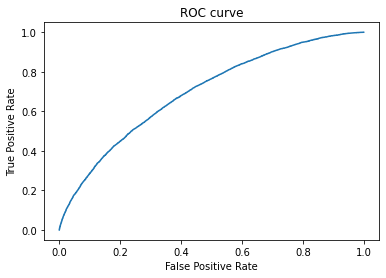

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_act, y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_act, y_pred))

In [37]:
loss, accuracy = model.evaluate(X_new_pad, y_act, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

704/704 [==============================] - 30s 43ms/step - loss: 0.7527 - accuracy: 0.6383
Test: accuracy = 0.638311  ;  loss = 0.752654
